In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2022-04-21 09:55:18.874191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 09:55:18.874216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Chargement des données

In [2]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# Les étiquettes: données labélisées
labels = raw_data[:, -1]

# les données ECG

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalisation des données

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

2022-04-21 09:59:59.892540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 09:59:59.892570: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 09:59:59.892594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-04-21 09:59:59.892871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Entrâinement sur les données ECG normales étiquettés :1 d'où la séparation entre les ECG normaux et anormaux

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

# représentation d'un signal normal ECG 

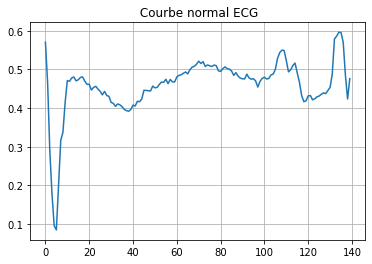

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title(" Courbe normal ECG")
plt.show()

# signal anormal ECG 


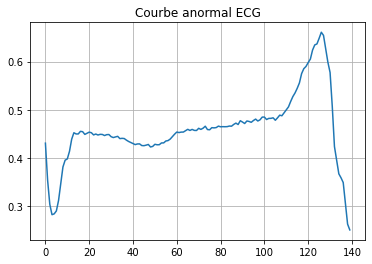

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("Courbe anormal ECG")
plt.show()

# Construction de la VAE

In [8]:
# Couche d'échantillonage

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Construction de l'encodeur

def encoder_model(normal_train_data):
    encoder_inputs = tf.keras.Input(shape=(normal_train_data.shape[1]))
    x = layers.Dense(32, activation="relu")(encoder_inputs)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    
    # So far we just copied the network from above
    # Now we generate the latent space of mean and log-variance, in this case of dimension 8
    z_mean = layers.Dense(8, name="z_mean")(x)
    z_log_var = layers.Dense(8, name="z_log_var")(x)
    
    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [10]:
# Construction du decoder

def decoder_model(normal_train_data):
    # Recreate the network we used for the 'normal' autoencoder
    latent_inputs = tf.keras.Input(shape=(8,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    decoder_outputs = layers.Dense(normal_train_data.shape[1], activation="relu")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [11]:
# Construction de la VAE ainsi que calcul de la KL_loss et Loss_reconstruction

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
# compilation de l'encoder et du decoder

encoder = encoder_model(normal_train_data)
decoder = decoder_model(normal_train_data)

# combinaison de l'encoder et decoder

vae = VAE(encoder, decoder)

# Compilation du modèle

vae.compile(optimizer=tf.keras.optimizers.Adam(),loss='mae')

In [13]:
# Entraînement du modèle

history = vae.fit(normal_train_data, normal_train_data, 
          epochs=80, 
          batch_size=128,
          
          shuffle=True)

Epoch 1/80
19/19 [==============================] - 1s 3ms/step - loss: 3.5380 - reconstruction_loss: 3.5309 - kl_loss: 0.0071
Epoch 2/80
19/19 [==============================] - 0s 3ms/step - loss: 2.4543 - reconstruction_loss: 2.4458 - kl_loss: 0.0085
Epoch 3/80
19/19 [==============================] - 0s 3ms/step - loss: 1.7284 - reconstruction_loss: 1.7086 - kl_loss: 0.0198
Epoch 4/80
19/19 [==============================] - 0s 3ms/step - loss: 1.3060 - reconstruction_loss: 1.2825 - kl_loss: 0.0234
Epoch 5/80
19/19 [==============================] - 0s 3ms/step - loss: 1.1212 - reconstruction_loss: 1.1115 - kl_loss: 0.0097
Epoch 6/80
19/19 [==============================] - 0s 3ms/step - loss: 1.0319 - reconstruction_loss: 1.0270 - kl_loss: 0.0049
Epoch 7/80
19/19 [==============================] - 0s 3ms/step - loss: 0.9815 - reconstruction_loss: 0.9794 - kl_loss: 0.0020
Epoch 8/80
19/19 [==============================] - 0s 3ms/step - loss: 0.9569 - reconstruction_loss: 0.9527 - 

19/19 [==============================] - 0s 5ms/step - loss: 0.7397 - reconstruction_loss: 0.7395 - kl_loss: 1.9001e-04
Epoch 64/80
19/19 [==============================] - 0s 4ms/step - loss: 0.7403 - reconstruction_loss: 0.7401 - kl_loss: 2.0003e-04
Epoch 65/80
19/19 [==============================] - 0s 4ms/step - loss: 0.7389 - reconstruction_loss: 0.7387 - kl_loss: 1.8649e-04
Epoch 66/80
19/19 [==============================] - 0s 4ms/step - loss: 0.7391 - reconstruction_loss: 0.7389 - kl_loss: 2.0316e-04
Epoch 67/80
19/19 [==============================] - 0s 4ms/step - loss: 0.7381 - reconstruction_loss: 0.7379 - kl_loss: 1.8638e-04
Epoch 68/80
19/19 [==============================] - 0s 2ms/step - loss: 0.7379 - reconstruction_loss: 0.7377 - kl_loss: 1.6923e-04
Epoch 69/80
19/19 [==============================] - 0s 2ms/step - loss: 0.7381 - reconstruction_loss: 0.7379 - kl_loss: 1.6878e-04
Epoch 70/80
19/19 [==============================] - 0s 2ms/step - loss: 0.7372 - recons

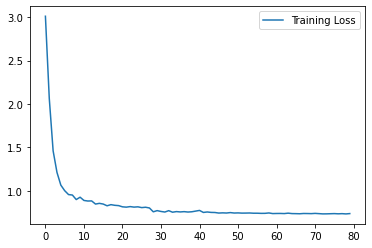

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

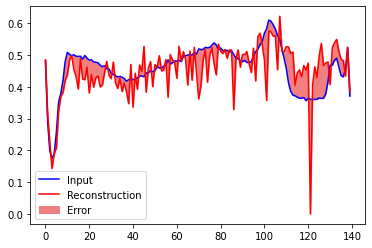

In [15]:
# Reconstruction d'une séquence normale ECG à partir des données de test_normal

z_mean, z_var, z  = vae.encoder.predict(normal_test_data)
x_reconst = vae.decoder.predict(z)



plt.plot(normal_test_data[0],'b')
plt.plot(x_reconst[0],'r')
plt.fill_between(np.arange(140), x_reconst[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

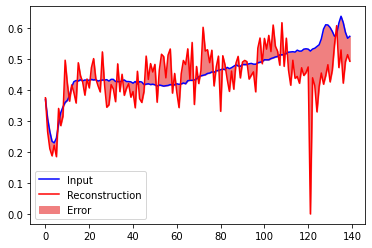

In [16]:
# Reconstruction d'une sequence anormale ECG à partir des données de test_anormal
anomalous_test_data
z_mean, z_var, z  = vae.encoder.predict(anomalous_test_data)
x_reconst = vae.decoder.predict(z)



plt.plot(anomalous_test_data[0],'b')
plt.plot(x_reconst[0],'r')
plt.fill_between(np.arange(140), x_reconst[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [19]:
# Tracer l'erreur de reconstruction sur des ECG normaux à partir de l'ensemble d'apprentissage
reconstructions = vae.encoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

InvalidArgumentError: Incompatible shapes: [2359,140] vs. [3,2359,8] [Op:Sub]